In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq

import matplotlib.pyplot as plt

In [16]:
def LLG(t, m, Beff, gammaLL, alpha):
    return -gammaLL * (np.cross(m, Beff) + alpha*np.cross(m, np.cross(m, Beff))) / (1 + alpha**2)

def LLG_tdep(t, m, f_Beff, gammaLL, alpha):
    Beff = f_Beff(t)
    return -gammaLL * (np.cross(m, Beff) + alpha*np.cross(m, np.cross(m, Beff))) / (1 + alpha**2)

def f_Bext_factory(Bext, w_cutoff, h):
    def inner(t):
        return np.array([h * np.sinc(w_cutoff * t / np.pi), 0, Bext])
    
    return inner

def LLG_explicit_real(t, mxp, Bext, Brms, wc, kappa, N, gammaLL, alpha):
    m = mxp[:-2]
    xp = mxp[-2:]
    
    Beff = Bext + Brms*xp[0]
    dm = -gammaLL * (np.cross(m, Beff) + alpha*np.cross(m, np.cross(m, Beff))) / (1 + alpha**2)
    
    M = np.array([[-kappa, -wc],
                 [wc, -kappa]])
    dxp = np.dot(M, xp)
    dxp[1] += -N * gammaLL * np.dot(Brms, m)
    
    return np.append(dm, dxp)

def LLG_explicit_real_tdep(t, mxp, f_Bext, Brms, wc, kappa, N, gammaLL, alpha):
    m = mxp[:-2]
    xp = mxp[-2:]
    Bext = f_Bext(t)
    
    Beff = Bext + Brms*xp[0]
    dm = -gammaLL * (np.cross(m, Beff) + alpha*np.cross(m, np.cross(m, Beff))) / (1 + alpha**2)
    
    M = np.array([[-kappa, -wc],
                 [wc, -kappa]])
    dxp = np.dot(M, xp)
    dxp[1] += -N * gammaLL * np.dot(Brms, m)
    
    return np.append(dm, dxp)

def fft_wrapper(time, timeseries, slice_=None):
    if slice_:
        time = time[slice_]
        timeseries = timeseries[slice_]
        
    ws = fftfreq(len(time), time[1] - time[0])
    amps = np.abs(fft(timeseries))
    
    return ws[:middle(ws)], amps[:middle(ws)]


def middle(seq):
    return len(seq) // 2

def free_photon_prop(w, wc):
    return 1 / (w - wc)

def photon_prop(w, wc, chi, lam):
    D0 = free_photon_prop(w, wc)
    return D0 - lam**2*D0*chi*D0

def polaritons(wz, wc, lam):
    def para(wz, wc, lam):
        innerroot = np.sqrt(wz**4 + wc**4 - 2*wz**2*wc**2 + 16*lam**2*wz*wc)
        return np.sqrt(0.5 * (wz**2 + wc**2 - innerroot)), np.sqrt(0.5 * (wz**2 + wc**2 + innerroot))
    
    def ferro(wz, wc, lam):
        mu = wz * wc / (4 * lam**2)
        g = lam * mu * np.sqrt(2 / (1 + mu))
        wztilde = wz * (1 + mu) / (2 * mu)
        eps = wz * (1 - mu) * (3 + mu) / (8 * mu * (1 + mu))
        
        innerroot = np.sqrt(wztilde**4 + wc**4 - 2*wztilde**2*wc**2 + 16*g**2*wztilde*wc + 4*(eps**2*wztilde**2 + eps*wztilde**3 - wc**2*eps*wztilde))
        return np.sqrt(0.5 * (wztilde**2 + wc**2 + 2*eps*wztilde - innerroot)), np.sqrt(0.5 * (wztilde**2 + wc**2 + 2*eps*wztilde + innerroot))
    
    if 4 * lam**2 < wz * wc:
        # paramagnetic phase
        return para(wz, wc, lam)
    else:
        # ferromagnetic phase
        return ferro(wz, wc, lam)

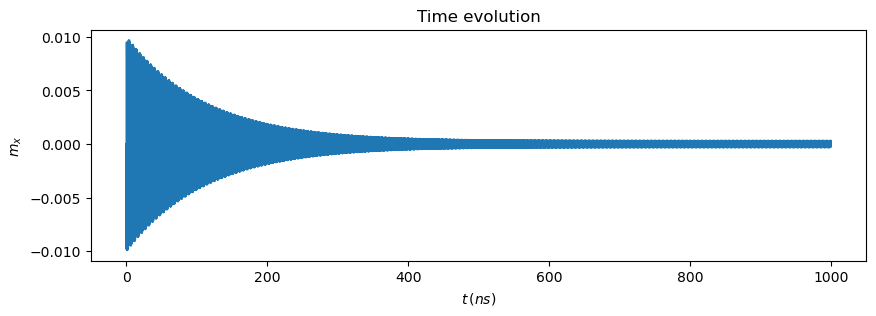

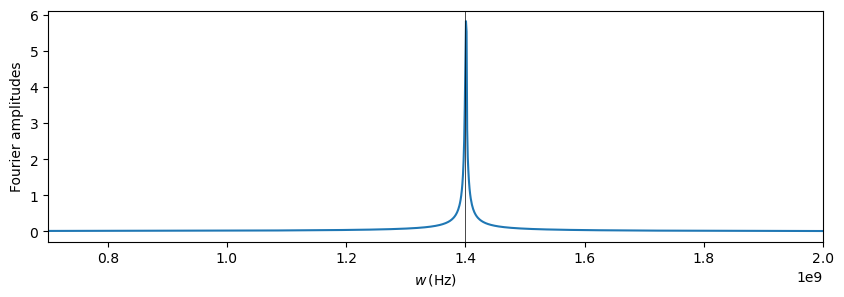

In [3]:
plt.rcParams['figure.figsize'] = (10, 3)

N = 100
tmax = 1000e-9
alpha = 1e-3
my0 = 0.01
m0 = np.array([0, my0, np.sqrt(1 - my0**2)])
gammaLL = 28e9 * 2*np.pi
wz = 1.4e9
Beff = np.array([0, 0, 2*np.pi*wz/gammaLL])
t_eval = np.linspace(0, tmax, 10000)
sol = solve_ivp(LLG, (0, tmax), m0, args=(Beff, gammaLL, alpha), t_eval=t_eval)
ws, amps = fft_wrapper(sol.t, sol.y[0])

plt.plot(sol.t * 1e9, sol.y[0])
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.show()
plt.plot(ws[:len(ws)//2], amps[:len(ws)//2])
plt.xlim(0.7e9, 2e9)
plt.ylabel('Fourier amplitudes')
plt.xlabel(r'$w \, ({\rm Hz})$')
plt.axvline(1.4e9, c='k', lw=0.5)
plt.show()

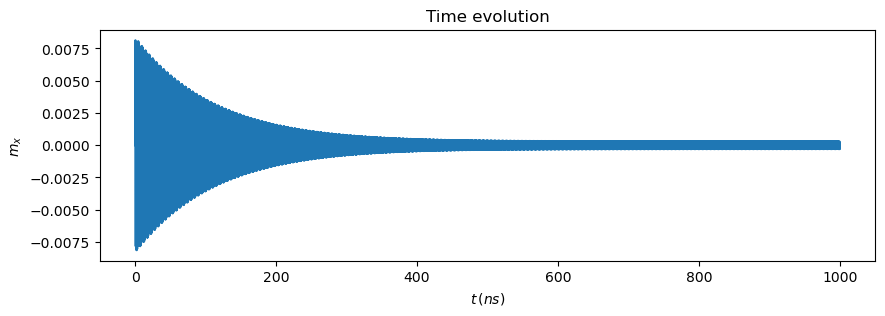

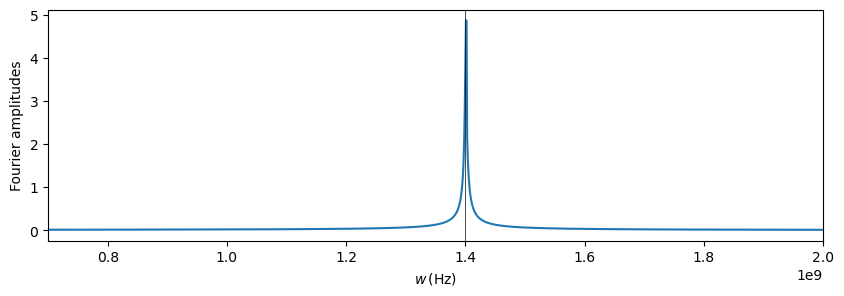

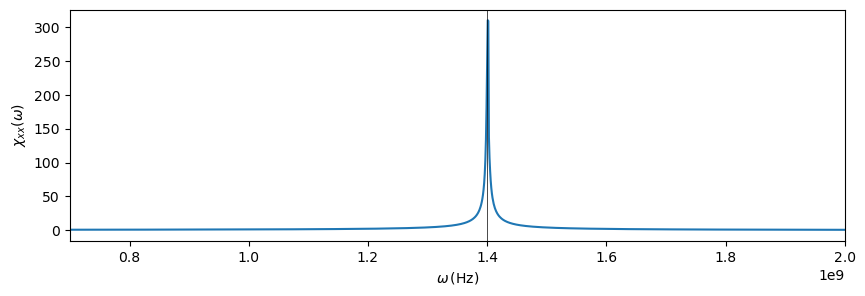

In [6]:
plt.rcParams['figure.figsize'] = (10, 3)

N = 10
tmax = 1000e-9
alpha = 1e-3
m0 = np.array([0, 0, 1])
gammaLL = 28e9 * 2*np.pi
wz = 1.4e9
w_cutoff = 2 * 2*np.pi*wz
Bext = 2*np.pi*wz/gammaLL
h = 0.01 * Bext
f_Beff = f_Bext_factory(Bext, w_cutoff, h)
t_eval = np.linspace(0, tmax, 10000)
sol = solve_ivp(LLG_tdep, (0, tmax), m0, args=(f_Beff, gammaLL, alpha), t_eval=t_eval)
ws, amps = fft_wrapper(sol.t, sol.y[0])

plt.plot(sol.t * 1e9, sol.y[0])
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.show()

plt.plot(ws, amps)
plt.xlim(0.7e9, 2e9)
plt.ylabel('Fourier amplitudes')
plt.xlabel(r'$w \, ({\rm Hz})$')
plt.axvline(1.4e9, c='k', lw=0.5)
plt.show()

chi = amps * w_cutoff / (gammaLL * h * np.pi)
plt.plot(ws, chi)
plt.xlim(0.7e9, 2e9)
plt.ylabel(r'$\chi_{xx}(\omega)$')
plt.xlabel(r'$\omega \, ({\rm Hz})$')
plt.axvline(1.4e9, c='k', lw=0.5)
plt.show()

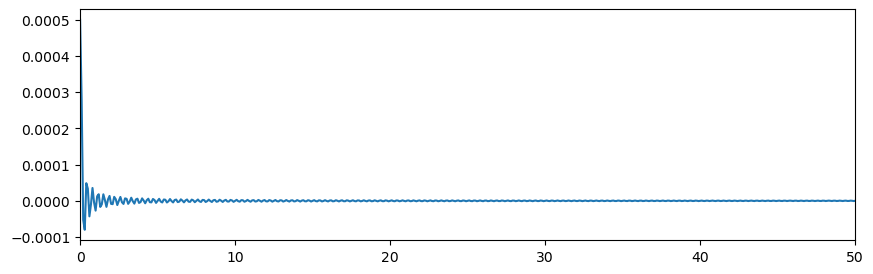

In [7]:
plt.plot(sol.t * 1e9, [f_Beff(t)[0] for t in sol.t])
plt.xlim(0, 50)
plt.show()

wzc/wc: 0.7466910823080258


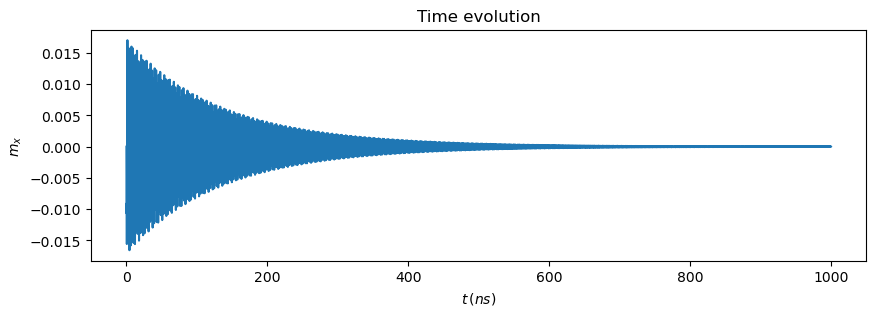

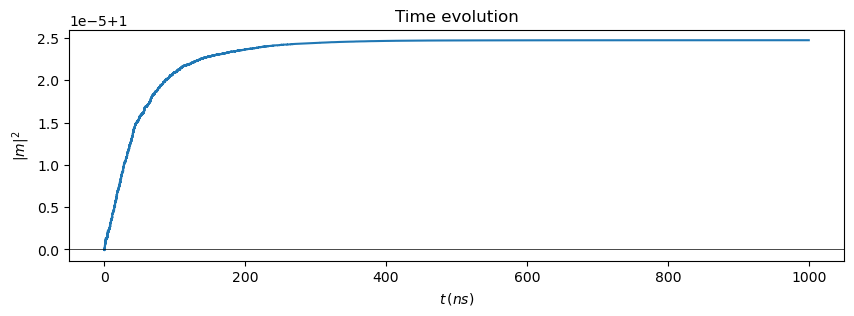

gap/lam: 1.153433211418139


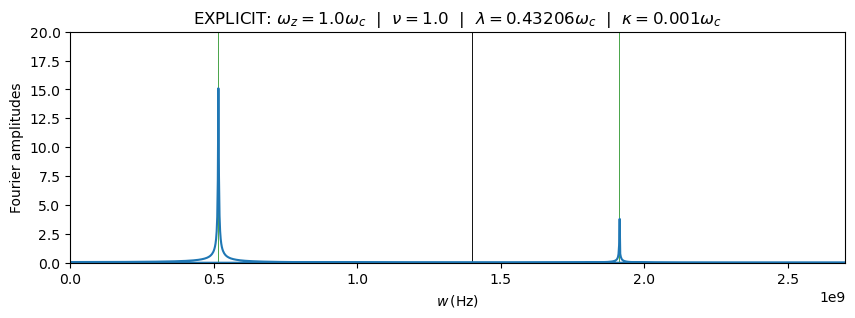

In [19]:

N = 1000
tmax = 1000e-9 #1000
alpha = 1e-3
my0 = 0.01
m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0])
gammaLL = 28e9 * 2*np.pi
wc = 1.4e9
wz = 1 * wc
kappa = 0.001 * wc
Bext = np.array([0, 0, 2*np.pi*wz/gammaLL])
nu = 1.0
c = 5.124350564859e-19
rho = 5.1e26 # densidad espines FIJA
lam = np.sqrt(c * rho * nu * wc)
Brms = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
Brms = np.array([Brms, 0, 0])
wzc = 4 * lam ** 2 / wc # freq espines critica, calculo indicativo
print('wzc/wc:', wzc / wc)

t_eval = np.linspace(0, tmax, 500000) #100000
#dt = 0.01e-9
sol = solve_ivp(LLG_explicit_real, (0, tmax), m0, method='RK45', args=(Bext, Brms, 2*np.pi * wc, 2*np.pi * kappa, N, gammaLL, alpha), t_eval=t_eval)#, max_step=dt, atol = 1, rtol = 1
ws = fftfreq(len(sol.t) // 2, sol.t[1] - sol.t[0]) # discard first half of time evolution
amps = np.abs(fft(sol.y[0][len(sol.t) // 2:])) # discard first half of time evolution
plt.plot(sol.t * 1e9, sol.y[0])

#plt.xlim(0, 50)
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.show()


plt.plot(sol.t * 1e9, [mx**2 + my**2 + mz**2 for mx, my, mz in zip(sol.y[0], sol.y[1], sol.y[2])])
plt.axhline(1.0, c='k', lw=0.5)
#plt.ylim(0, 1.1)
plt.ylabel(r'$|m|^2$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.show()

plt.axvline(wc, c='k',lw=0.5)
plt.axvline(wz, c='k',lw=0.5)

# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c='g', lw=0.5)
# -----------------------------------------

print('gap/lam:', (pp - pm) / (2 * lam)) 

plt.plot(ws, amps)
#plt.xlim(0.1e9, 2e9)
plt.ylim(0, 20)
plt.xlim(0.0e9, 2.7e9)
plt.ylabel('Fourier amplitudes')
plt.xlabel(r'$w \, ({\rm Hz})$')
plt.title('EXPLICIT: ' + rf'$\omega_z = {wz / wc} \omega_c$' + '  |  ' + rf'$\nu = {nu}$' + '  |  ' + rf'$\lambda = {round(lam/wc, 5)} \omega_c$' + '  |  ' + rf'$\kappa = {round(kappa/wc, 5)} \omega_c$')

plt.show()



wzc/wc: 0.7466910823080258


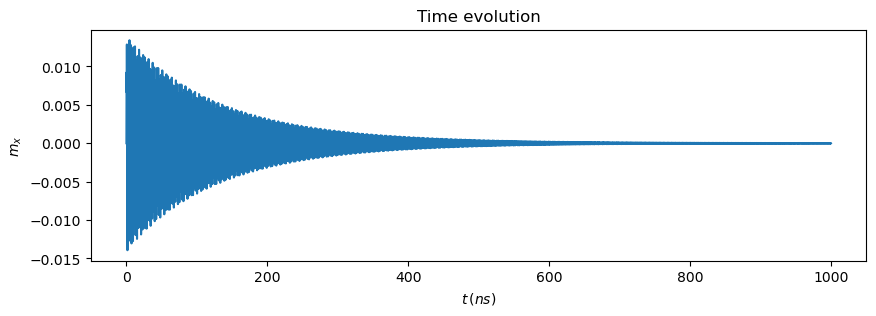

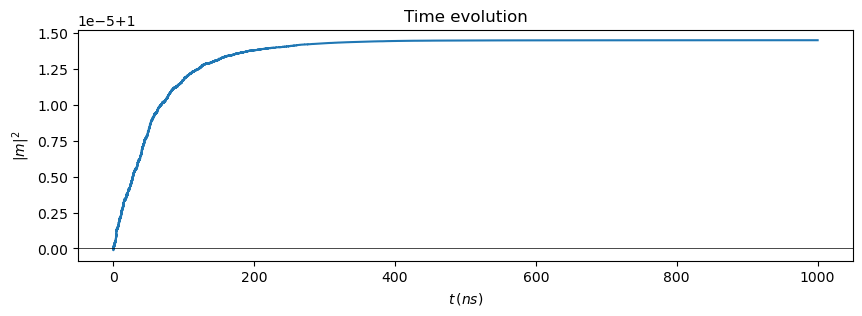

gap/lam: 1.153433211418139


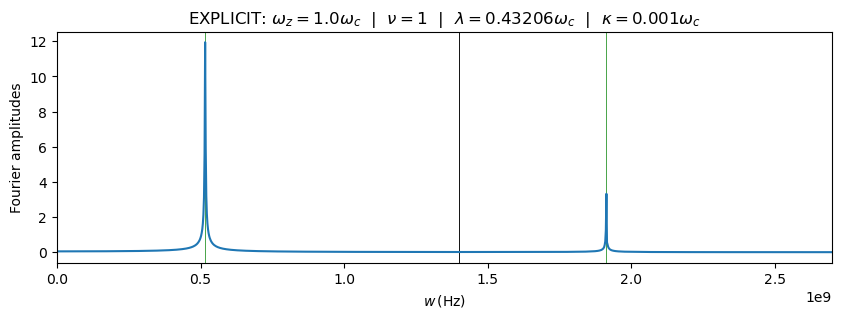

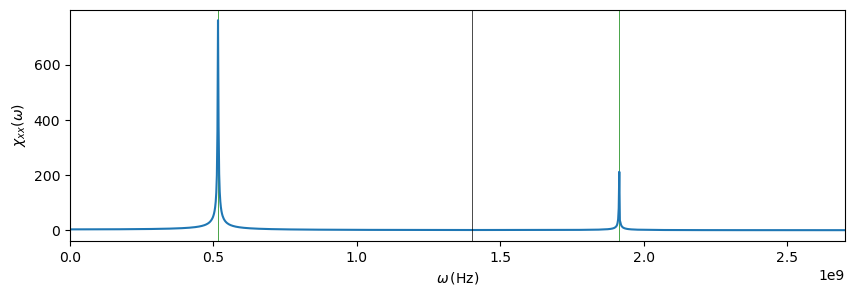

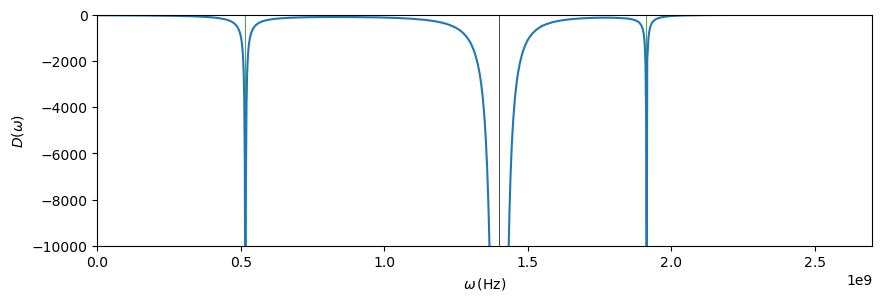

In [34]:
N = 1000
tmax = 1000e-9 #1000
alpha = 1e-3
m0 = np.array([0, 0, 1, 0, 0])
gammaLL = 28e9 * 2*np.pi
wc = 1.4e9
wz = 1 * wc
w_cutoff = 2 * 2*np.pi*wz
Bext = 2*np.pi*wz/gammaLL
h = 0.01 * Bext
f_Bext = f_Bext_factory(Bext, w_cutoff, h)
kappa = 0.001 * wc
Bext = np.array([0, 0, 2*np.pi*wz/gammaLL])
nu = 1
c = 5.124350564859e-19
rho = 5.1e26 # densidad espines FIJA
lam = np.sqrt(c * rho * nu * wc)
Brms = Brms_scalar = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
Brms = np.array([Brms, 0, 0])
wzc = 4 * lam ** 2 / wc # freq espines critica, calculo indicativo
print('wzc/wc:', wzc / wc)

t_eval = np.linspace(0, tmax, 500000) #100000
#dt = 0.01e-9
sol = solve_ivp(LLG_explicit_real_tdep, (0, tmax), m0, method='RK45', args=(f_Bext, Brms, 2*np.pi * wc, 2*np.pi * kappa, N, gammaLL, alpha), t_eval=t_eval)#, max_step=dt, atol = 1, rtol = 1
ws, amps = fft_wrapper(sol.t, sol.y[0], slice(middle(sol.t), -1)) # discard first half of time evolution
plt.plot(sol.t * 1e9, sol.y[0])

#plt.xlim(0, 50)
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.show()


plt.plot(sol.t * 1e9, [mx**2 + my**2 + mz**2 for mx, my, mz in zip(sol.y[0], sol.y[1], sol.y[2])])
plt.axhline(1.0, c='k', lw=0.5)
#plt.ylim(0, 1.1)
plt.ylabel(r'$|m|^2$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.show()

plt.axvline(wc, c='k',lw=0.5)
plt.axvline(wz, c='k',lw=0.5)

# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c='g', lw=0.5)
# -----------------------------------------

print('gap/lam:', (pp - pm) / (2 * lam)) 

plt.plot(ws, amps)
#plt.xlim(0.1e9, 2e9)
#plt.ylim(0, 20)
plt.xlim(0.0e9, 2.7e9)
plt.ylabel('Fourier amplitudes')
plt.xlabel(r'$w \, ({\rm Hz})$')
plt.title('EXPLICIT: ' + rf'$\omega_z = {wz / wc} \omega_c$' + '  |  ' + rf'$\nu = {nu}$' + '  |  ' + rf'$\lambda = {round(lam/wc, 5)} \omega_c$' + '  |  ' + rf'$\kappa = {round(kappa/wc, 5)} \omega_c$')

plt.show()

# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c='g', lw=0.5)
# -----------------------------------------

chi = amps * w_cutoff / (gammaLL * h * np.pi)
plt.plot(ws, chi)
plt.xlim(0.0e9, 2.7e9)
plt.ylabel(r'$\chi_{xx}(\omega)$')
plt.xlabel(r'$\omega \, ({\rm Hz})$')
plt.axvline(1.4e9, c='k', lw=0.5)
plt.show()

# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c='g', lw=0.5)
# -----------------------------------------

plt.plot(ws, photon_prop(ws, wc, chi, np.sqrt(N) * gammaLL * Brms_scalar / 2))
plt.ylim(-1e4, 0)
plt.xlim(0.0e9, 2.7e9)
plt.ylabel(r'$D(\omega)$')
plt.xlabel(r'$\omega \, ({\rm Hz})$')
plt.axvline(1.4e9, c='k', lw=0.5)
plt.show()

